# State Redistribution for Discontinuous Galerkin in 1D
This is a short tutorial on the state redistribution method for discontinuous Galerkin methods in 1D. State redistribution is a method that solves small-cell problem when using a cut-cell grid. 

First, we create a 1D meshgrid with some cut cells on it. Suppose that the domain is $[0, L]$ and we have $N$ elements. Also, we have cut cells with cell indices $x_i$, $i\in [1, n]$, and each of them has a relative size $\alpha_i$, $i\in [1, n]$. For a 1D domain $[0, L]$, we can uniquely determine the size of a full cell: $$h = L / \left(N-n+\sum_{i=1}^n \alpha_i\right).$$

Below, the function `mesh_generator(L, N, alpha, positions)` generates a non-uniform mesh grid in the 1D domain $[0, L]$.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

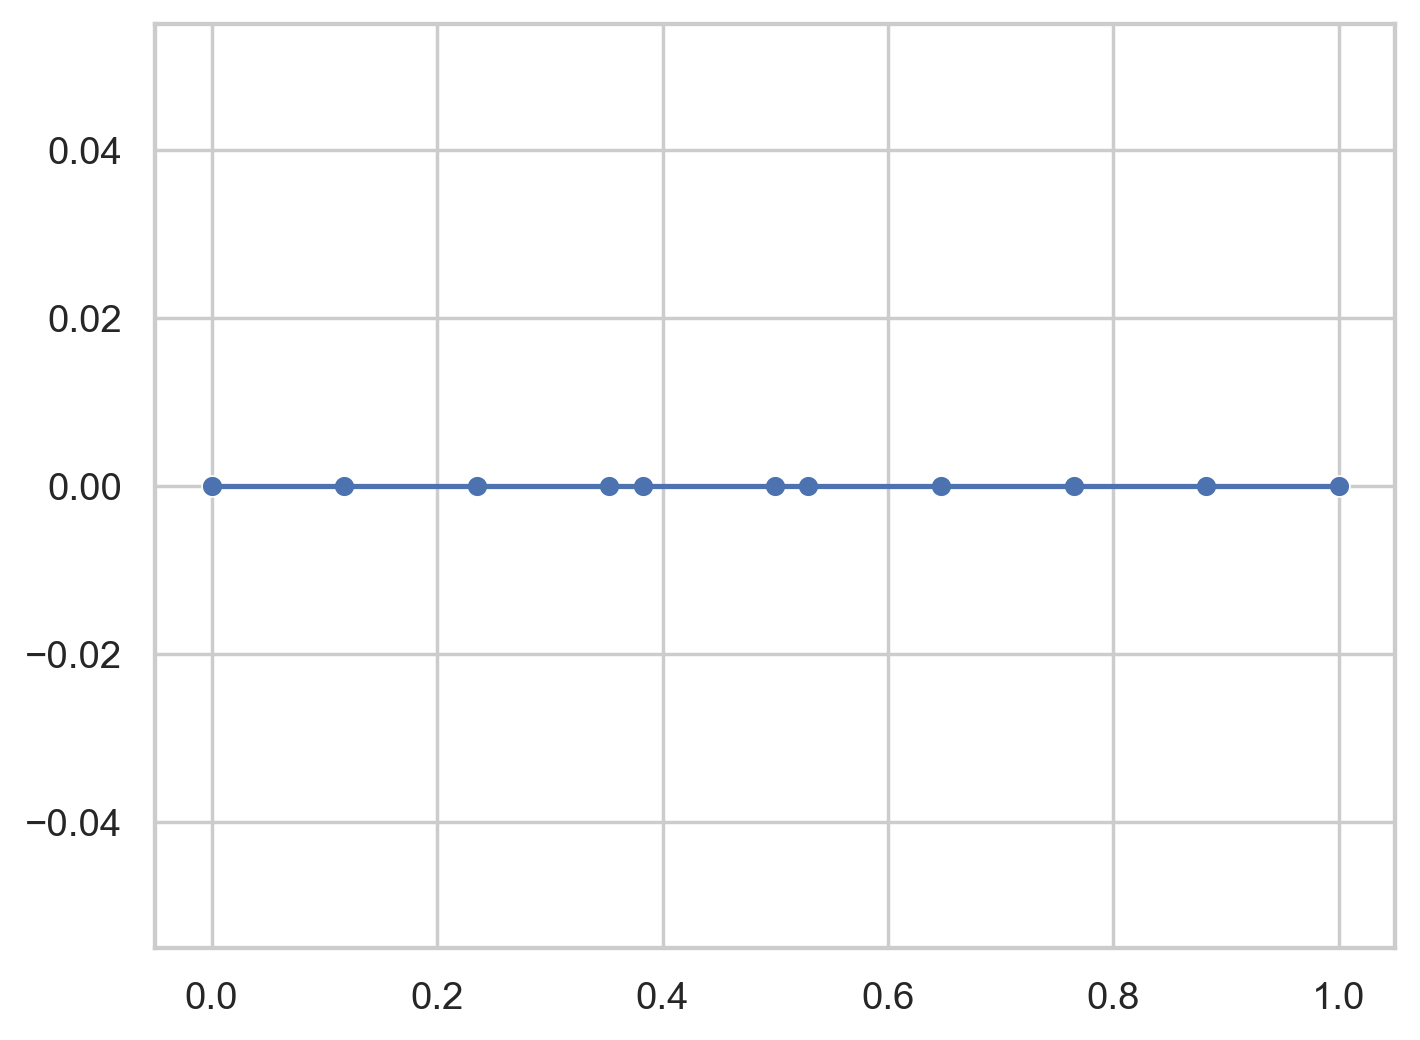

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import legendre
import seaborn as sns
from rich import print
from tqdm import tqdm
from types import FunctionType as function


sns.set()
sns.set_style("whitegrid")


def do_op(f, xs):
    """
    `do_op(f, xs)` 

    Performs function `f` to every component of `xs` and returns the results in a vector.

    ### Parameters:
    `f`: a function that takes a scalar as input and returns a scalar.
    `xs`: a vector of scalars.

    ### Return:
    `results`: a vector of scalars, the result of applying `f` to every component of `xs`.
    """ 
    results = np.zeros(len(xs))
    for i in range(len(xs)):
        results[i] = f(xs[i])
    return results

# Problem setup
L:float     = 1.0  # Domain bounds
N:int       = 10  # Number of elements
p:int       = 4  # Polynomial degree
f:function  = lambda x: np.sin(2*np.pi*x)  # RHS function

def mesh_generator(L, N, alphas, positions):
    """
    `mesh_generator(L, N, alphas, positions)`
    
    Generate a cut-cell mesh in a 1D domain of length `L` with `N` elements.

    ### Parameters:
    `L`: length of the domain.
    `N`: Number of elements.
    `alphas`: a list containing the relative size of the cut cells (alpha \in [0,1]).
    `positions`: a list containing the positions of the cut cells (position \in [0,N]).

    ### Return:
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    `h`: a scalar containing the full cell width.
    `h_local`: a 1D array of size N containing the width of each element.
    """
    assert np.size(alphas) == np.size(positions), "Incompatible size of alphas and positions"
    h = L / (N - np.size(alphas) + np.sum(alphas)) # global cell width
    nodes = np.linspace(0, N, N + 1) * h
    for i in range(np.size(alphas)):
        nodes[positions[i]:] -= h * (1-alphas[i])
    h_local = np.diff(nodes)
    nodes = np.array([nodes[0:-1], nodes[1:]])
    return nodes, h, h_local

nodes, h, h_local = mesh_generator(L, N, [1/4, 1/4], [N//2-1, N//2+1])
fig, ax = plt.subplots(dpi=250)
sns.scatterplot(x=np.append(nodes[0,:], [L]), y=np.zeros(N+1))
sns.lineplot(x=np.append(nodes[0,:], [L]), y=np.zeros(N+1))
plt.show()

The next step is to perform a preprocessing step to the meshgrid. For cut cell $x_i$ with relative cell size $\alpha_i<0.5$, we need to merge the cell with its left and right neighbors. Both the number of merged cells that one original cell belongs to and the indices of the original cells that are covered by each merged cell will be recorded.

In [6]:
def preprocess(nodes, h_local, h):
    """
    `preprocess(nodes, h_local, h)`
    
    Preprocess the mesh to prepare for state redistribution.
    
    ### Parameters:
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    `h_local`: a 1D array of size N containing the width of each element.
    `h`: a scalar containing the full cell width.
    
    ### Return:
    `merged_nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh after merging small cells.
    `overlap`: a list of lists, where each inner list contains the indices of the merged cells that overlap on each original cell.
    `merged_ind`: a list of lists, where each inner list contains the indices of the original cells are covered by each merged cell.
    """
    merged_nodes = np.zeros(np.shape(nodes))
    merged_ind = []
    overlap = [ [] for _ in range(N) ]
    for i in range(N):
        ind = []
        if h_local[i] >= 0.5 * h:
            merged_nodes[:, i] = nodes[:, i]
            overlap[i].append(i)
            ind.append(i)
        else: # not sure: what if two or more small cut cells are close?
            merged_nodes[0, i] = nodes[0, (i-1) % N]
            overlap[(i-1) % N].append(i)
            ind.append((i-1) % N)

            overlap[i].append(i)
            ind.append(i)

            merged_nodes[1, i] = nodes[1, (i+1) % N]
            overlap[(i+1) % N].append(i)
            ind.append((i+1) % N)
        
        merged_ind.append(ind)

    return merged_nodes, overlap, merged_ind

merged_nodes, overlap, merged_ind = preprocess(nodes, h_local, h)

overlap_counts = np.int64(do_op(len, overlap))
print("The merged nodes are: ")
display(merged_nodes)
print("Overlap counts are: ")
display(overlap_counts)
print("Each merged element contains the following cells: ")
display(merged_ind)

The merged nodes are:

array([[0.        , 0.11764706, 0.23529412, 0.23529412, 0.38235294,
        0.38235294, 0.52941176, 0.64705882, 0.76470588, 0.88235294],
       [0.11764706, 0.23529412, 0.35294118, 0.5       , 0.5       ,
        0.64705882, 0.64705882, 0.76470588, 0.88235294, 1.        ]])

Overlap counts are:

array([1, 1, 2, 1, 3, 1, 2, 1, 1, 1])

Each merged element contains the following cells:

[[0], [1], [2], [2, 3, 4], [4], [4, 5, 6], [6], [7], [8], [9]]

We are now ready to define a weighted inner product on each merged cell. For a full-size cell, its merged cell is itself, so it is just the standard inner product: $$\left<f, g\right>_{\hat{K}_i}=\frac{1}{h}\int_{K_i}f\ g\ dx;$$ For a small cell, the inner product is defined differently. For example, the fourth merged cell covers original cells $\{K_2,K_3,K_4\}$; we then look at the overlap count of each of these original cells: 
- for $K_2$ the overlap count is $2$; 
- for $K_3$ the overlap count is $1$;
- for $K_4$ the overlap count is $3$.

The weighted inner product is then defined as $$\left<f, g\right>_{\hat{K}_3}=\frac{1}{h/2+\alpha h + h/3}\left(\frac{1}{2}\int_{K_2}f\ g\ dx +\int_{K_3}f\ g\ dx + \frac{1}{3}\int_{K_4}f\ g\ dx \right).$$

The following function `weighted_inner(f, g, ind, h_local, overlap_counts, nodes)` implements this weighted inner product.

We can find a set of basis functions that are orthonormal with respect to this specific set of inner products. We use a standard Gram-Schmidt algorithm to find the basis functions.

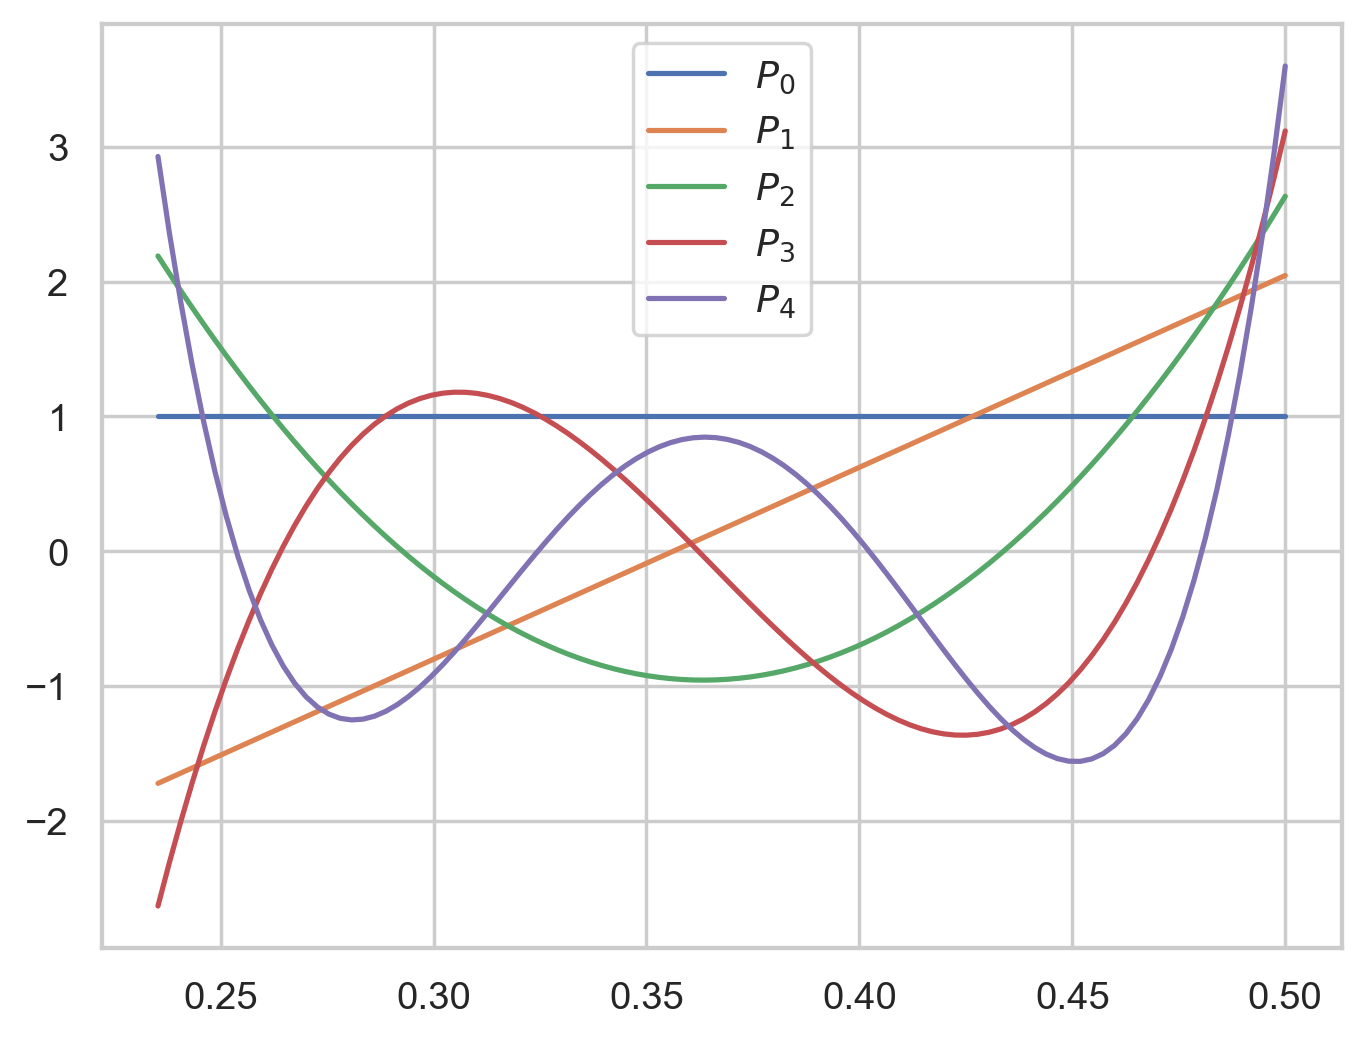

In [7]:
def weighted_inner(f:function, g:function, ind, h_local, overlap_counts, nodes):
    """
    `weighted_inner(f, g, ind, h_local, overlap_counts, nodes)`
    
    Performs a weighted inner product between two functions `f` and `g` on the merged mesh cell which covers the original cells that are indexed by `ind`.
    
    ### Parameters:
    `f`: a function that takes a scalar as input and returns a scalar.
    `g`: a function that takes a scalar as input and returns a scalar.
    `ind`: a list containing the indices of the original cells that are covered by the merged cell.
    `h_local`: a 1D array of size N containing the width of each element.
    `overlap_counts`: a 1D array of size N containing the number of merged cells that overlap on each original cell.
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    
    ### Return:
    `result`: a scalar, the weighted inner product between `f` and `g` on the merged mesh cell.
    """
    H = 0
    result = 0
    func = lambda x: f(x) * g(x)
    for i in ind:
        H += h_local[i] / overlap_counts[i]
        result += integrate.quad(func, nodes[0, i], nodes[1, i])[0] / overlap_counts[i]
    return result / H

def find_basis(ind, h_local, overlap_counts, nodes, p):
    """
    `find_basis(ind, h_local, overlap_counts, nodes, p)`
    
    Performs Gram-Schmidt to find the basis functions for the merged mesh cell which covers the original cells that are indexed by `ind`.
    
    ### Parameters:
    `ind`: a list containing the indices of the original cells that are covered by the merged cell.
    `h_local`: a 1D array of size N containing the width of each element.
    `overlap_counts`: a 1D array of size N containing the number of merged cells that overlap on each original cell.
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    `p`: a scalar, the polynomial degree.
    
    ### Return:
    `Polys`: a list of functions, the basis functions for the merged mesh cell.
    """
    Polys = []
    for i in range(p+1):
        Pi = legendre(i)
        for j in range(i):
            Pi = Pi - Polys[j] * weighted_inner(Pi, Polys[j], ind, h_local, overlap_counts, nodes)
        Pi = Pi / np.sqrt(weighted_inner(Pi, Pi, ind, h_local, overlap_counts, nodes))
        Polys.append(Pi)
    return Polys

Polys = find_basis(merged_ind[3], h_local, overlap_counts, nodes, p)

refined_x = np.linspace(merged_nodes[0, 3], merged_nodes[1, 3], 100)
fig, ax = plt.subplots(dpi=250)
for i in range(p+1):
    ax.plot(refined_x, Polys[i](refined_x), label=f"$P_{i}$")
ax.legend()
plt.show()

In [9]:
def find_local_basis(merged_ind, h_local, overlap_counts, nodes, p):
    """
    `find_local_basis(merged_ind, h_local, overlap_counts, nodes, p)`
    
    Find the basis function for each merged cell.
    
    ### Parameters:
    `merged_ind`: a list of lists, where each inner list contains the indices of the original cells that are covered by each merged cell.
    `h_local`: a 1D array of size N containing the width of each element.
    `overlap_counts`: a 1D array of size N containing the number of merged cells that overlap on each original cell.
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    `p`: a scalar, the polynomial degree.
    
    ### Return:
    `local_basis`: a list of lists, where each inner list contains the basis functions for each merged cell.
    """
    local_basis = []
    for i in range(N):
        local_basis.append(find_basis(merged_ind[i], h_local, overlap_counts, nodes, p))
    return local_basis

local_basis = find_local_basis(merged_ind, h_local, overlap_counts, nodes, p)
print("The local basis functions are:")
display(local_basis)

The local basis functions are:

[[poly1d([1.]),
  poly1d([29.44486373, -1.73205081]),
  poly1d([ 969.33546825, -114.03946685,    2.23606798]),
  poly1d([ 3.24964405e+04, -5.73466597e+03,  2.69866634e+02, -2.64575131e+00]),
  poly1d([ 1.09621312e+06, -2.57932500e+05,  1.95075000e+04, -5.10000000e+02,
          3.00000000e+00])],
 [poly1d([1.]),
  poly1d([29.44486373, -5.19615242]),
  poly1d([ 969.33546825, -342.11840056,   29.06888371]),
  poly1d([ 32496.44047815, -17203.9979002 ,   2968.53297101,   -166.6823326 ]),
  poly1d([ 1.09621312e+06, -7.73797500e+05,  2.01577500e+05, -2.29500000e+04,
          9.63000000e+02])],
 [poly1d([1.]),
  poly1d([29.44486373, -8.66025404]),
  poly1d([ 969.33546825, -570.19733426,   82.73451517]),
  poly1d([ 32496.44047815, -28673.32983366,   8365.86564559,   -806.95414987]),
  poly1d([ 1096213.12499973, -1289662.49999981,   565717.49999997,
          -109650.00000001,     7923.        ])],
 [poly1d([1.]),
  poly1d([14.23524617, -5.07251419]),
  poly1d([ 192.08042069, -139.56065101,   

We now initialize our solver. First, we represent the initial condition $u_0(x)$ in terms of our basis functions. Here, we choose our basis functions as a translated and scaled version of Legendre polynomials: $$\varphi_j^l(x) = \sqrt{\frac{2}{h_j}}\sqrt{\frac{2l+1}{2}}P_l\left(\frac{2(x-x_j)}{h_j}\right).$$ With this normalization, we have $$\left<\varphi_j^l(x), \varphi_j^m(x)\right>=\delta_{lm}.$$

We then define the initial condition as a linear combination of these basis functions: $$u_0(x) \approx\sum_{j=0}^{N}\sum_{l=0}^p\alpha_{jl}\varphi_j^l(x).$$

We then use the `evaluate_sol` function to evaluate our solution at any point inside our domain.

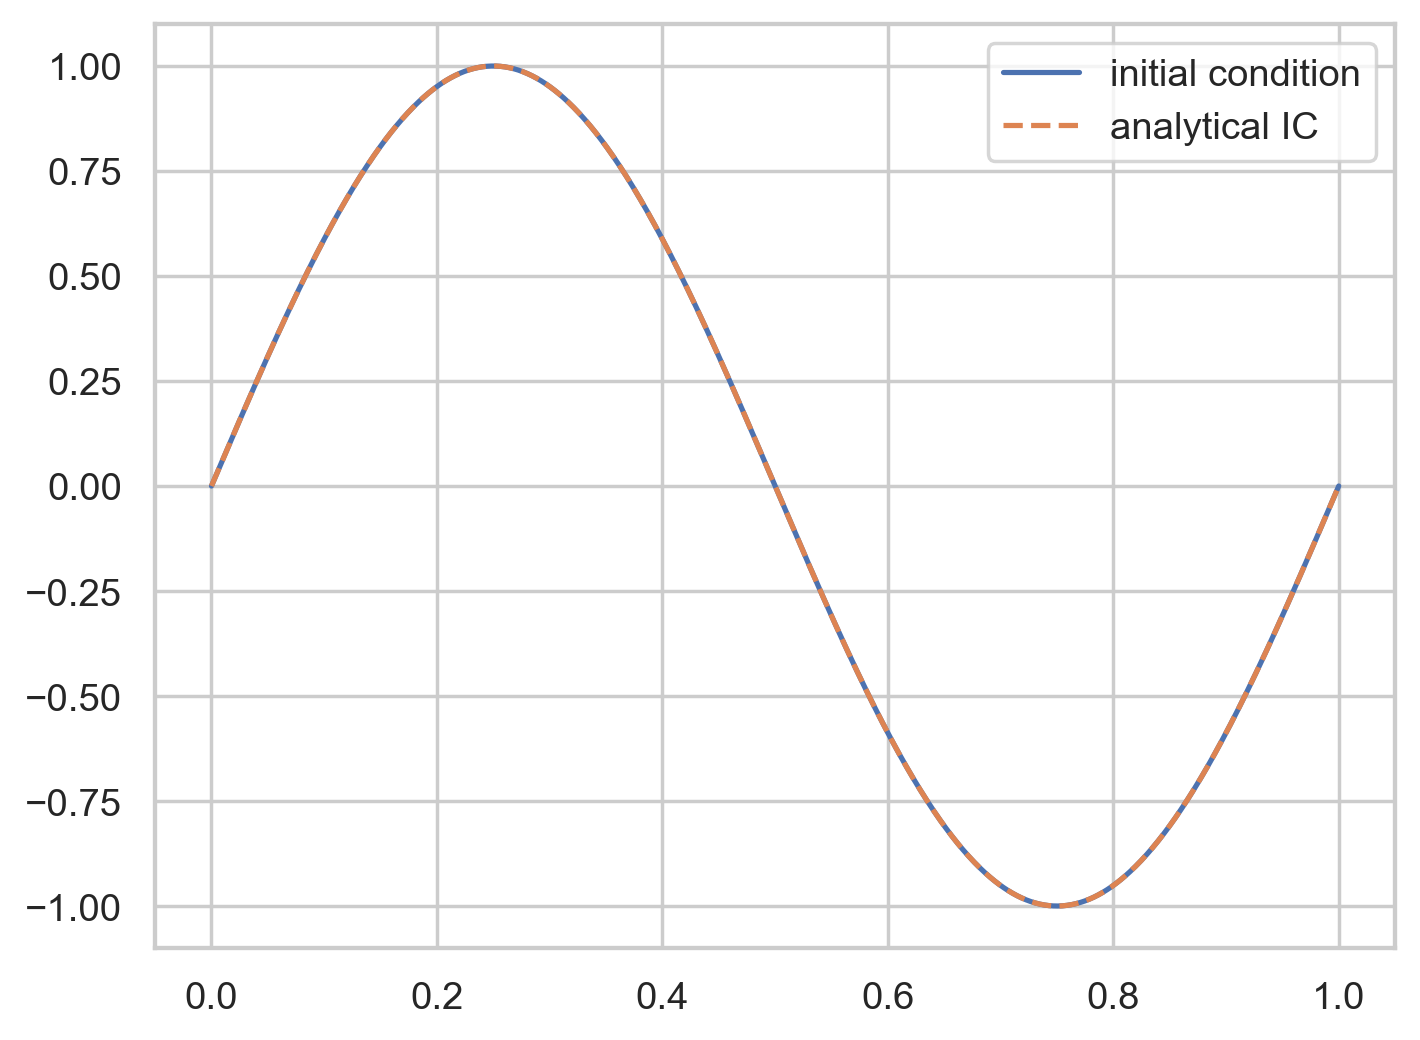

In [10]:
def initialize(f, nodes, h_local, p):
    """
    `initialize(f, nodes, h_local, p)`
    
    Initialize the solution $u_0(x)$ using the given initial condition `f`.
    
    ### Parameters:
    `f`: a function that takes a scalar as input and returns a scalar.
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    `h_local`: a 1D array of size N containing the width of each element.
    `p`: a scalar, the polynomial degree.
    
    ### Return:
    `U`: a 2D array of shape (p+1, N) containing the coefficients of the basis functions.
    """
    N = np.shape(nodes)[1]
    U = np.zeros((p+1, N))
    for i in range(N):
        for j in range(p+1):
            # Legendre polynomial normalization factor
            phi = lambda x: np.sqrt((2*j+1)/h_local[i]) * legendre(j)(2*(x - (nodes[0, i] + nodes[1, i]) / 2) / h_local[i])
            # Adjusted function for projection onto the j-th Legendre polynomial
            func = lambda x: f(x) * phi(x)
            # Project and normalize
            U[j, i] = integrate.quad(func, nodes[0, i], nodes[1, i])[0]
    return U

def evaluate_sol(U, h_local, nodes):
    """
    `evaluate_sol(U, h_local, nodes)`
    
    Returns a function `f` which takes in the position `x` and evaluates the solution value at that point.
    
    ### Parameters:
    `U`: a 2D array of shape (p+1, N) containing the coefficients of the basis functions.
    `h_local`: a 1D array of size N containing the width of each element.
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    
    ### Return:
    `f`: a function that takes in the position `x` and evaluates the solution value at that point.
    """
    def f(x):
        u = 0
        index = 0
        while x > nodes[1, index]:
            index += 1
        coeffs = U[:, index]
        psi = (x - (nodes[0, index] + nodes[1, index]) / 2) * 2 / h_local[index]
        for j in range(p+1):
            u += np.sqrt((2*j+1)/h_local[index]) * legendre(j)(psi) * coeffs[j]
        return u
    return f


U       = initialize(f, nodes, h_local, p)
func_U  = evaluate_sol(U, h_local, nodes)
xs      = np.linspace(0, L, 1000)
us      = do_op(func_U, xs)
fig, ax = plt.subplots(dpi=250)
ax.plot(xs, us, label="initial condition")
ax.plot(xs, f(xs), label="analytical IC", linestyle="--")
ax.legend()
plt.show()

Each merged cell is assigned with a local coarsening matrix $C_j$. If the original cell is a large cell, then the merged cell is equivalent to the original cell, so $C_j=I$; otherwise, $C_j$ is not a square matrix. For example, $C_3$ is defined as $$C_3 = \frac{1}{h/N_2+\alpha h / N_3 + h/N_4}\begin{pmatrix}\hat{\varphi}_{3, 0}\\\hat{\varphi}_{3, 1}\\ \vdots \\ \hat{\varphi}_{3, p}\end{pmatrix}\begin{pmatrix}\varphi_{2, 0}/N_2 & \cdots & \varphi_{2, p}/N_2 & \varphi_{3, 0}/N_3 & \cdots & \varphi_{3, p}/N_3 & \varphi_{4, 0}/N_4 & \cdots & \varphi_{4, p}/N_4\end{pmatrix}$$ where $N_j$ is the overlap count of the $j$-th element.

Similarly, every original cell is assigned with a local redistribution matrix $R_j$. Depending on the overlap count, $R_j$ may appear in different shape. For example, cell $K_4$ has an overlap count $3$ and is overlapped by $\hat{K}_3, \hat{K}_4, $ and $\hat{K}_5$, so its redistribution matrix is $$R_4 = \frac{1}{h_4N_4}\begin{pmatrix}\varphi_{4, 0}\\\varphi_{4, 1}\\ \vdots \\ \varphi_{4, p}\end{pmatrix}\begin{pmatrix}\hat{\varphi}_{3, 0} & \cdots & \hat{\varphi}_{3, p} & \hat{\varphi}_{4, 0} & \cdots & \hat{\varphi}_{4, p} & \hat{\varphi}_{5, 0} & \cdots & \hat{\varphi}_{5, p}\end{pmatrix}$$

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

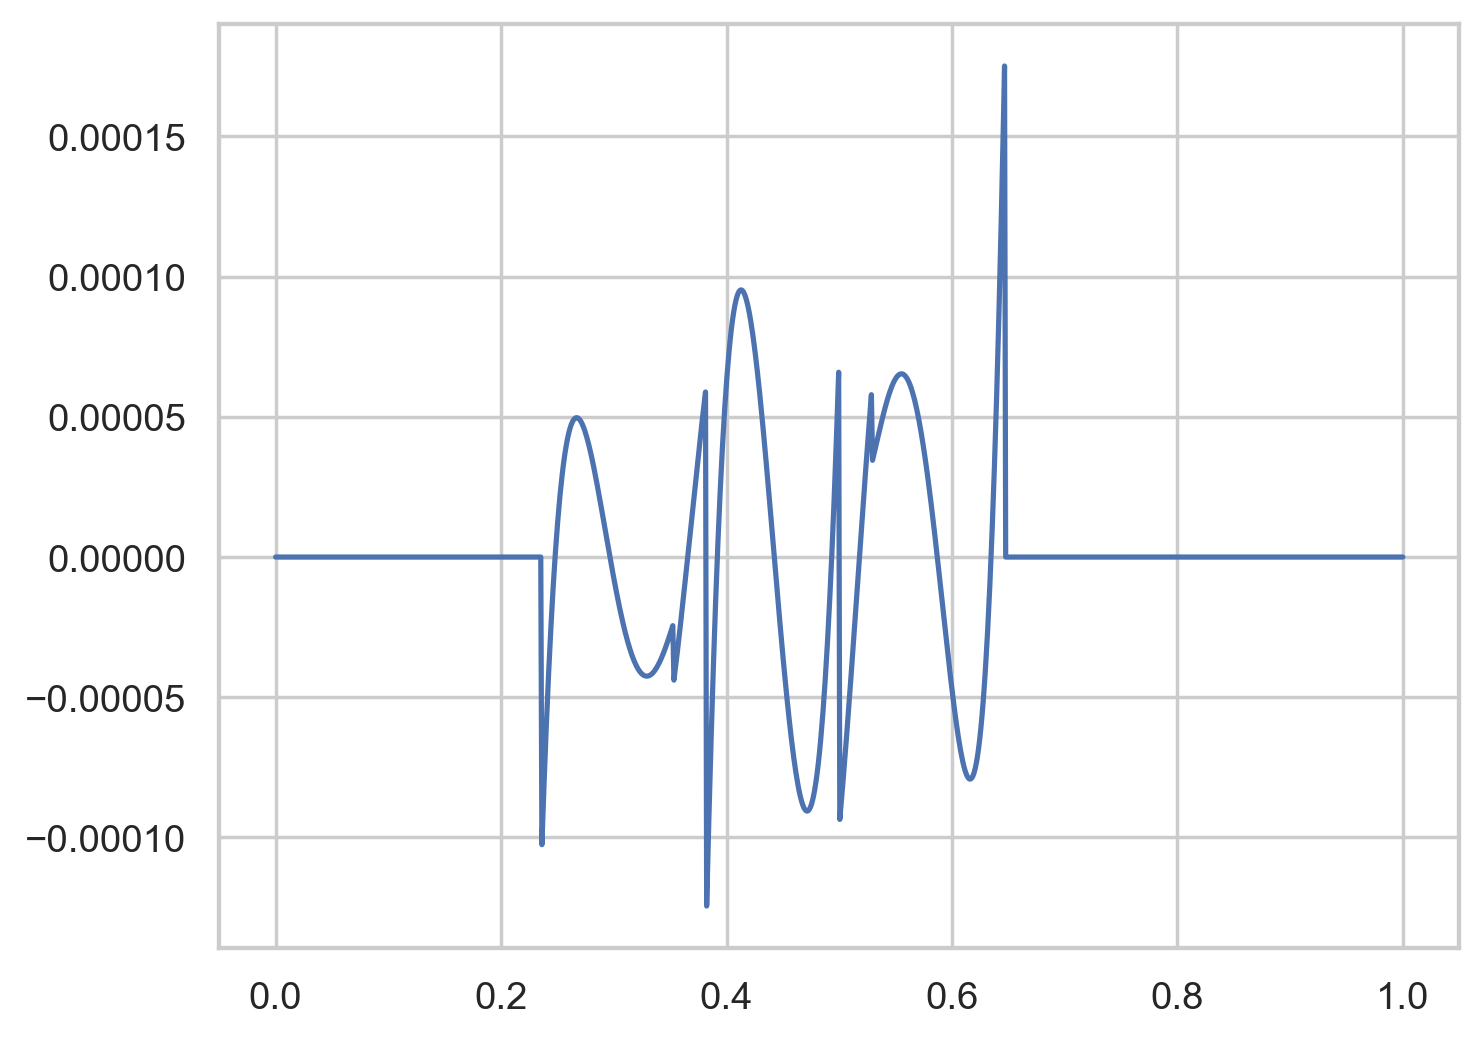

In [12]:
coarsen_M = []
for i in range(N):
    M = np.zeros((p+1, (p+1) * len(merged_ind[i])))
    H = 0
    for K in range(len(merged_ind[i])):
        k = merged_ind[i][K]
        H += h_local[k] / overlap_counts[k]
        for j in range(p+1):
            merged_basis = local_basis[i][j]            
            for l in range(p+1):
                unmerged_basis = lambda x: np.sqrt((2*l+1)/h_local[k]) * legendre(l)(2*(x - (nodes[0, k] + nodes[1, k]) / 2) / h_local[k])
                func = lambda x: merged_basis(x) * unmerged_basis(x)
                M[j, K * (p+1) + l] = integrate.quad(func, nodes[0, k], nodes[1, k])[0] / overlap_counts[k]
    coarsen_M.append(M / H)

def Coarsen(U, merged_ind, p, coarsen_M):
    """
    `Coarsen(U, merged_ind, p, coarsen_M)`
    
    Performs the coarsening step of the state redistribution method.
    
    ### Parameters:
    `U`: a 2D array of shape (p+1, N) containing the coefficients of the basis functions.
    `merged_ind`: a list of lists, where each inner list contains the indices of the original cells that are covered by each merged cell.
    `p`: a scalar, the polynomial degree.
    `coarsen_M`: a list of local coarsening matrices, where each local coarsening matrix is a matrix of shape (p+1, (p+1) * len(merged_ind[i])).
    
    ### Return:
    `Q`: a 2D array of shape (p+1, N) containing the coefficients of the basis functions on the merged cells.
    """
    Q = np.zeros(np.shape(U))
    for i in range(N):
        c = np.zeros((p+1) * len(merged_ind[i]))
        for K in range(len(merged_ind[i])):
            k = merged_ind[i][K]
            c[K * (p+1): (K+1) * (p+1)] = U[:, k]
        Q[:, i] = coarsen_M[i] @ c
    return Q

redistribute_M = []
for i in range(N):
    M = np.zeros((p+1, (p+1) * overlap_counts[i]))
    H = h_local[i]
    for k in range(overlap_counts[i]):
        for j in range(p+1):
            unmerged_basis = lambda x: np.sqrt((2*j+1)/h_local[i]) * legendre(j)(2*(x - (nodes[0, i] + nodes[1, i]) / 2) / h_local[i])
            for l in range(p+1):
                merged_basis = local_basis[overlap[i][k]][l]
                func = lambda x: merged_basis(x) * unmerged_basis(x)
                M[j, k * (p+1) + l] = integrate.quad(func, nodes[0, i], nodes[1, i])[0] / overlap_counts[i]
    redistribute_M.append(M)

def Redistribute(Q, overlap, overlap_counts, p, redistribute_M):
    """
    `Redistribute(Q, overlap, overlap_counts, p, redistribute_M)`
    
    Performs the redistribution step of the state redistribution method.
    
    ### Parameters:
    `Q`: a 2D array of shape (p+1, N) containing the coefficients of the basis functions on the merged cells.
    `overlap`: a list of lists, where each inner list contains the indices of the merged cells that overlap on each original cell.
    `overlap_counts`: a 1D array of size N containing the number of merged cells that overlap on each original cell.
    `p`: a scalar, the polynomial degree.
    `redistribute_M`: a list of local redistribution matrices, where each local coarsening matrix is a matrix of shape (p+1, (p+1) * overlap_counts[i]).
    
    ### Return:
    `U_SRD`: a 2D array of shape (p+1, N) containing the coefficients of the basis functions on the base grid after state redistribution 🍻.
    """
    U_SRD = np.zeros(np.shape(Q))
    for i in range(N):
        c = np.zeros((p+1) * overlap_counts[i])
        for k in range(overlap_counts[i]):
            c[k * (p+1): (k+1) * (p+1)] = Q[:, overlap[i][k]]
        U_SRD[:, i] = redistribute_M[i] @ c
    return U_SRD

U_SRD = Redistribute(Coarsen(U, merged_ind, p, coarsen_M), overlap, overlap_counts, p, redistribute_M)

func_U_SRD = evaluate_sol(U_SRD, h_local, nodes)
xs = np.linspace(0, L, 1000)
us = do_op(func_U_SRD, xs) - do_op(func_U, xs)
fig, ax = plt.subplots(dpi=250)
sns.lineplot(x=xs, y=us)
plt.show()

100%|██████████| 100/100 [00:00<00:00, 197.72it/s]


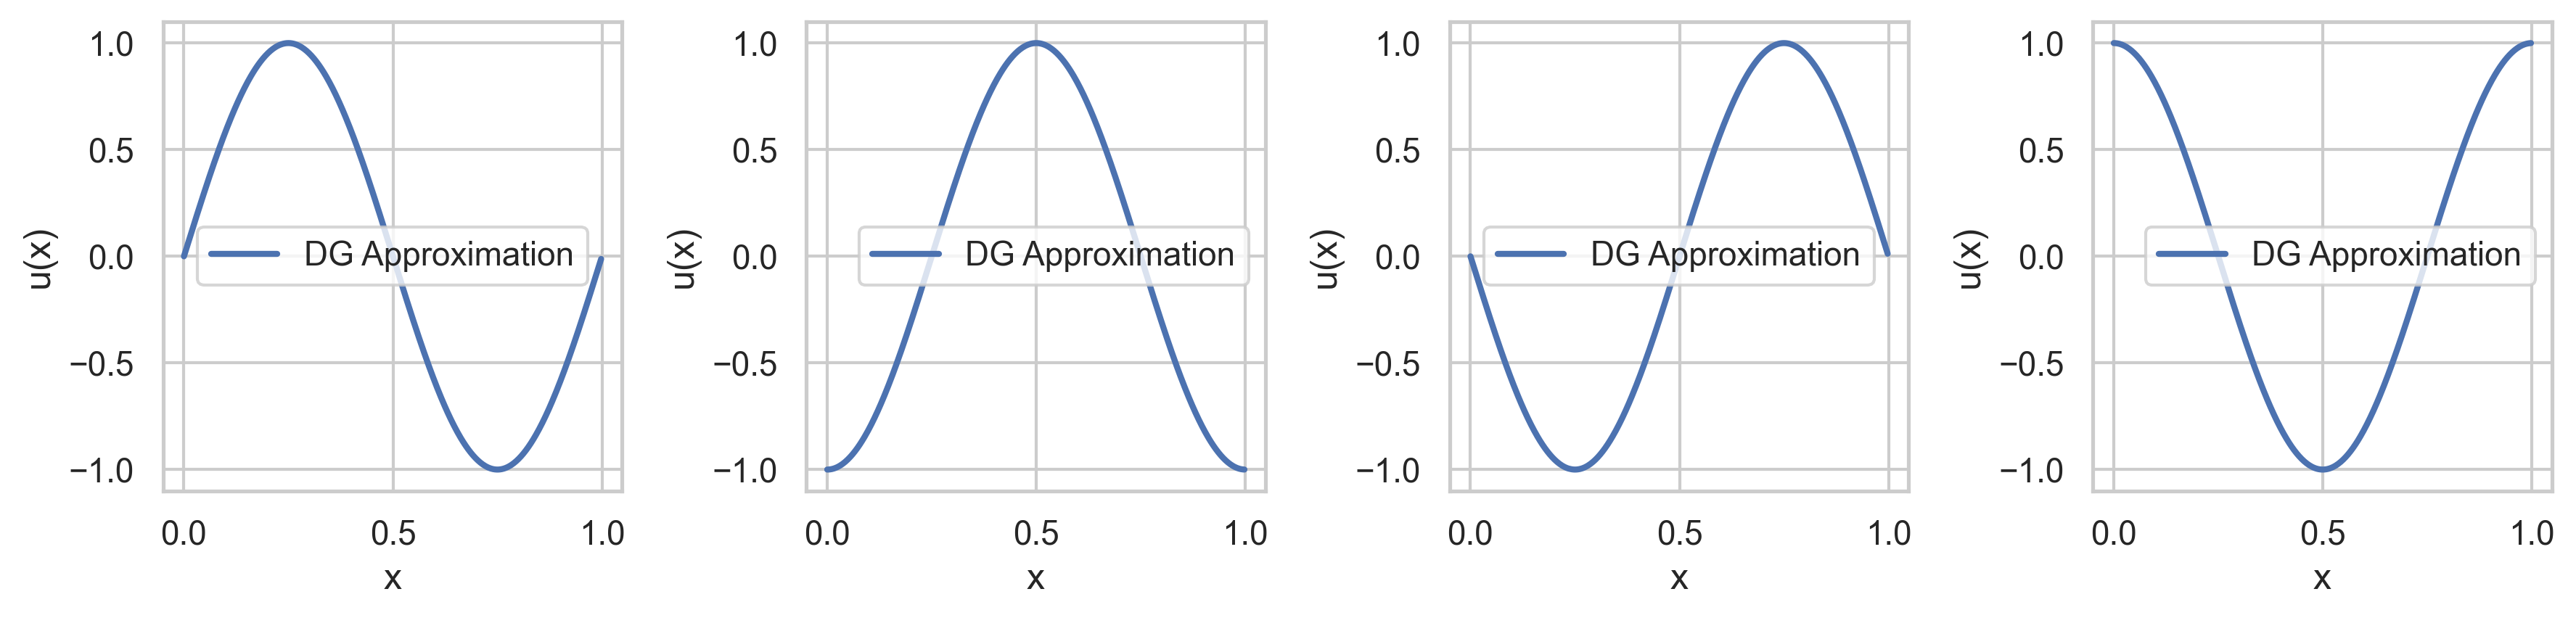

In [7]:
K = np.zeros((p+1, p+1))
phi_l = np.zeros(p+1)
phi_r = np.zeros(p+1)
for i in range(p+1):
    phi1 = lambda x: np.sqrt(2*i+1)*legendre(i)(x)
    phi_l[i] = phi1(-1)
    phi_r[i] = phi1(1)
    for j in range(p+1):
        # Stiffness matrix with correct normalization and derivative scaling
        phi2p = lambda x : np.sqrt(2*j+1)*np.polyder(legendre(j))(x)
        K[j, i] = integrate.quad(lambda x: phi1(x) * phi2p(x), -1, 1)[0] # Notice here K is NOT symmetric!!!

def local_K(h):
    return K / h

def local_phi_l(h):
    return phi_l / np.sqrt(h)

def local_phi_r(h):
    return phi_r / np.sqrt(h)

def Euler_forward(dt, U, p, h_local, overlap, merged_ind, overlap_counts):
    N = np.size(U, 1)
    M = np.eye(p+1)
    new_U = np.zeros((np.size(U, 0), np.size(U, 1)))
    for j in range(N):
        RHS = M @ U[:, j]
        RHS += local_K(h_local[j]) @ U[:, j] * dt

        ## flux terms
        f_left = np.dot(U[:, (j - 1) % N], local_phi_r(h_local[(j - 1) % N]))
        f_right = np.dot(U[:, j % N], local_phi_r(h_local[j])) 
        RHS += dt * (local_phi_l(h_local[j]) * f_left - local_phi_r(h_local[j]) * f_right)

        new_U[:, j] = np.linalg.solve(M, RHS)
        
    new_U = Redistribute(Coarsen(new_U, merged_ind, p, coarsen_M), overlap, overlap_counts, p, redistribute_M)
    return new_U

def RK2(dt, U, p, h_local, overlap, merged_ind, overlap_counts):
    U_1 = Euler_forward(dt, U, p, h_local, overlap, merged_ind, overlap_counts)
    new_U = U / 2 + Euler_forward(dt, U_1, p, h_local, overlap, merged_ind, overlap_counts) / 2
    return new_U

def RK3(dt, U, p, h_local, overlap, merged_ind, overlap_counts):
    U_1 = Euler_forward(dt, U, p, h_local, overlap, merged_ind, overlap_counts)
    U_2 = 3 * U / 4 + Euler_forward(dt, U_1, p, h_local, overlap, merged_ind, overlap_counts) / 4
    new_U = U / 3 + 2 * Euler_forward(dt, U_2, p, h_local, overlap, merged_ind, overlap_counts) / 3
    return new_U


fig, ax = plt.subplots(1,4,figsize=(12, 3), dpi=300)
NT = 100
dt = 1 / NT
refined_x = np.linspace(0, 1, 512, endpoint=False)
for i in tqdm(range(NT)):
    if i % (NT // 4) == 0:
        func_U = evaluate_sol(U, h_local, nodes)
        us = do_op(func_U, refined_x)
        ax[i//(NT // 4)].plot(refined_x, us, label="DG Approximation", linewidth=2)
        ax[i//(NT // 4)].legend()
        ax[i//(NT // 4)].set_xlabel("x")
        ax[i//(NT // 4)].set_ylabel("u(x)")
    U = RK3(dt, U, p, h_local, overlap, merged_ind, overlap_counts)
plt.tight_layout()
plt.show()